# Exploring My Favorite Playlist from Spotify

#### By using Spotify API Python wrapper called Spotipy, I extract and play around with a playlist of my favorite tracks (about 80 songs).

In [2]:
from math import pi
import pandas as pd
import numpy as np
import requests
import base64
import json
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import time

In [153]:
# initialize and authorize SpotipyOAuth 

usn = 'h_vy'
cid = '24da2914fefb43e198bf76d87e121f9c'
csc = '79bc72fb858041078caac075f9c369dd'
rur = 'http://localhost'
scp = 'user-read-private'

oam = spotipy.oauth2.SpotifyOAuth(username=usn, scope=scp, client_id=cid, client_secret=csc, redirect_uri=rur)
spo = spotipy.Spotify(oauth_manager=oam)

## Track Features
Spotify categorizes each song into about a dozen features. I decided to leave out key, tempo and mode as they are categorical values. Every other feature takes a continuous value within a range.

In [20]:
# feature categories
cat = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# shorten category names by taking first 4 characters
cat_sh = [c[:4] for c in cat]
# indices of feature categories
cat_ind = [1, 2, 4, 7, 8, 9, 10, 11]

In [7]:
# tracks of Fav playlist
fav_tracks = spo.playlist_tracks('2LlQtAk2KbOAGqgPwOUn9J')

In [34]:
"""
build and return a DataFrame of Track IDs and Names of Playlist Tracks
:trackJson: JSON Response, or Python dict, of Playlist Tracks
"""
def getTrackDf(trackJson):
    tracks = []
    for i in fav_tracks['items']:
        track = []
        track.append(i['track']['id'])
        track.append(i['track']['name'])
        track.append(i['track']['artists'][0]['name'])
        tracks.append(track)
    df = pd.DataFrame(data=tracks, columns=['id', 'name', 'artist'])
    df.set_index('id')
    return df

"""
build and return a DataFrame of Features of Multiple Tracks that 
include all features, track names and track IDs
:trackDf: list of track IDs 
:trackJson: JSON Response/Python dict of Tracks
"""
def getFeatureDf(featuresJson):
    featureDf = pd.DataFrame(featuresJson).set_index('id')

    # drop irrelevant columns
    featureDf.drop(['type', 'uri','track_href','analysis_url'], axis=1, inplace=True)

    # rescaling loudness
    minx = -60
    maxx = 0
    featureDf.insert(loc=3, column='norm_loudness', value=(featureDf['loudness']-minx)/(maxx-minx))
    featureDf.rename(columns={'loudness':'raw_loudness', 'norm_loudness':'loudness'}, inplace=True)

    return featureDf

In [27]:
trackDf = getTrackDf(fav_tracks)

In [28]:
favIds = trackDf.id.tolist()

In [29]:
fav_ft = spo.audio_features(favIds)

In [36]:
featureDf = getFeatureDf(fav_ft)

In [37]:
fullFtDf = pd.merge(featureDf, trackDf, left_on='id', right_on='id')

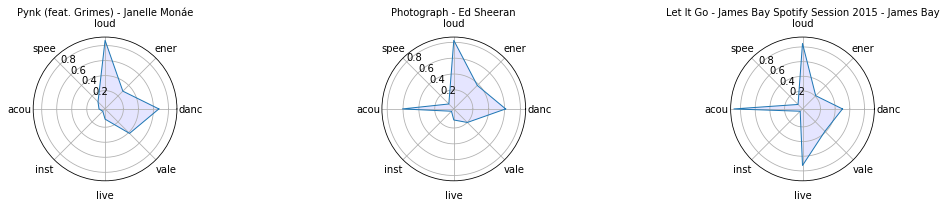

In [99]:
nrows, ncols = 1, 3

# initialize the radar graph for multiple track
fig, axs = plt.subplots(nrows, ncols, subplot_kw=dict(polar=True), figsize=(ncols*5, nrows*3))
plt.subplots_adjust(wspace=0.1)

# initialize indices for Axes list
if nrows != 1: 
    l = [(x, y) for x in range(nrows) for y in range(ncols)]
else: l = [y for y in range(ncols)]

# graph
for i, row in zip(l, fullFtDf.loc[[5, 7, 9]].iterrows()):
    # list of categories
    n = len(cat)
    trackFt = row[1][cat].values.tolist()
    
    # duplicate first value to close the plot
    trackFt += trackFt[:1]

    angles = [i / float(n) * 2 * pi for i in range(n)]
    angles += angles[:1]

    # configure axes
    ax = axs[i]
    thetaticks = np.arange(0,360,45)
    ax.set_thetagrids(thetaticks, labels=cat_sh, fontsize=10)
    ax.set_rlabel_position(135)
    ax.set_title(pad=15, fontdict={'fontweight':'book'}, label=row[1][-2]+ " - " + row[1][-1], size=10)
    ax.set_rticks(np.arange(0.2,0.8,0.2))
    ax.set_rmax(20)
    
    # plot and fill
    ax.plot(angles, trackFt, linewidth=1, linestyle='solid')
    ax.fill(angles, trackFt, 'b', alpha=0.1)

#plt.suptitle('Features of Favorite Tracks', weight='semibold', size=13)
plt.tight_layout()
plt.savefig(fname='../docs/assets/img/tracks.png', dpi='figure', bbox_inches='tight')
plt.show()

In [117]:
fullFtDf.loc[fullFtDf.name.str.contains('Hotel')]

id  danceability  energy  key  loudness  raw_loudness  \
69  2GpBrAoCwt48fxjgjlzMd4          0.55    0.49    2  0.821133       -10.732   

    mode  speechiness  acousticness  instrumentalness  liveness  valence  \
69     1       0.0572         0.368            0.0001     0.917    0.609   

     tempo  duration_ms  time_signature                                  name  \
69  74.656       432040               4  Hotel California - Live On MTV, 1994   

    artist  
69  Eagles

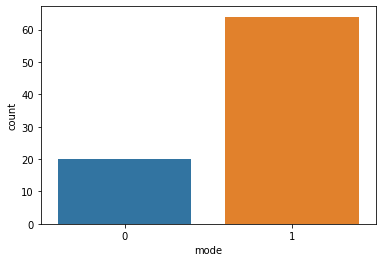

In [159]:
# count songs in Major vs Minor mode
sns.countplot(x='mode', data=fullFtDf)
plt.show()

In [108]:
# count songs by artists, then see 10 artists with the most songs
fullFtDf.groupby('artist').agg({'id':'count'}).sort_values(by='id', ascending=False).head(10)

id
artist           
BIGBANG         4
Charlie Puth    4
Khalid          3
James Bay       3
Ed Sheeran      3
Davichi         3
LANY            2
Da LAB          2
Vũ.             2
Sơn Tùng M-TP   2

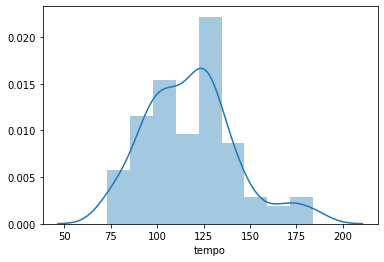

In [111]:
sns.distplot(fullFtDf.tempo)
plt.show()

In [112]:
fullFtDf.tempo.mean()

117.77213095238093

## Track Analysis
Spotify also analyzes a track by segmenting it into multiple subparts, each with its own features. 

In [118]:
# get audio analysis for Hotel California, live acoustic version
tr_a = spo.audio_analysis('2GpBrAoCwt48fxjgjlzMd4')

In [119]:
tr_a.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'sections', 'segments', 'tatums'])

In [141]:
sm = tr_a['segments'] # 327 - index to 120s
bt = tr_a['beats'] # 330
br = tr_a['bars'] # 83
st = tr_a['sections'] # 4
tt = tr_a['tatums'] # 660

### Visualizing the first 30s of the track

By doing this we understand how the song is segmented and how it sounds changes over different parts: intro, verse, chorus, bridge, outro

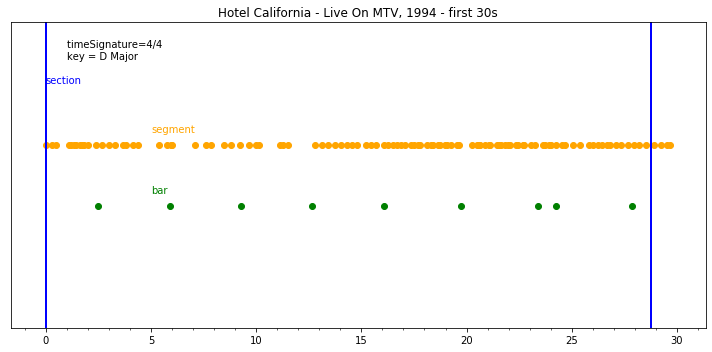

In [147]:
def get_s(l):
    return [i['start'] for i in l]

st_s = get_s(st[:2])
br_s = get_s(br[:9])
sm_s = get_s(sm[:110])

fig, ax = plt.subplots(figsize=(10,5))

ax.bar(st_s, [2.5]*len(st_s), width=0.1, color='blue')
ax.scatter(sm_s, y=[1.5]*len(sm_s), color='orange')
ax.scatter(br_s, y=[1]*len(br_s), color='green')


ax.annotate('section',
            xy=(0, 2),
            fontsize='medium', color='blue')
ax.annotate('segment', color='orange',
            xy=(5, 1.6),
            fontsize='medium')
ax.annotate('bar', color='green',
            xy=(5, 1.1),
            fontsize='medium')
ax.annotate('timeSignature=4/4 \nkey = D Major',
            xy=(1, 2.2), ha='left',
            fontsize='medium')

#ax.set_xlim(right=30)
ax.set_ylim(top=2.5)

ax.yaxis.set_visible(False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.title(fullFtDf.name[fullFtDf.id=='2GpBrAoCwt48fxjgjlzMd4'].values[0] + ' - first 30s')
fig.tight_layout()
plt.savefig('../docs/assets/img/spotify_2.png')
plt.show()

In [154]:
## Get top tracks and artists. This requires using a different scope which needs a new OAuth Manager
scp_top = 'user-top-read'

oam_top = spotipy.oauth2.SpotifyOAuth(username=usn, scope=scp_top, client_id=cid, client_secret=csc, redirect_uri=rur)
spo_top = spotipy.Spotify(oauth_manager=oam_top)
top_arts = spo_top.current_user_top_artists(limit=50)
[i['name'] for i in top_arts['items']] 

Using `localhost` as redirect URI without a port. Specify a port (e.g. `localhost:8080`) to allow automatic retrieval of authentication code instead of having to copy and paste the URL your browser is redirected to.


Enter the URL you were redirected to:  http://localhost/?code=AQCHBZI1bnoSBba8fFcvH2y0EsfqLqbPOtZ5-uK_nnzLGZIQlLBgPp_8yPqUx66h4O7SiUtb57SzzivbekKwnPnYW8MfdvsRXw9YcNqVJUax64w-fJM4PFnBeBY4IyXyWsW-uXzxwa5xTWJpKOd-1BEPwMR0YTPZjqPIB-Pob9-ZrMw


['Bleachers',
 'BIGBANG',
 'Ariana Grande',
 'Post Malone',
 'Davichi',
 'Westlife',
 'Christina Perri',
 'James Bay',
 'BLACKPINK',
 'Huh Gak',
 'James Arthur',
 'Gentle Bones',
 'Lorde',
 'Maroon 5',
 'Eric Nam',
 'Little Mix',
 'Lauv',
 'John Legend',
 'Charlie Puth',
 'Linkin Park',
 'Arctic Monkeys',
 'Vitaa',
 'Fall Out Boy',
 'TAEYEON',
 'James TW',
 'New Politics',
 'Ed Sheeran']

In [155]:
# get top tracks
top_tracks = spo_top.current_user_top_tracks(limit=50)

In [170]:
[i['name'] for i in top_tracks['items']]

['Animal',
 '너는 나만큼 (Growing Pains)',
 'Wild Heart',
 'Circles',
 'You & Me',
 'Marry Your Daughter',
 'Can You Feel the Love Tonight',
 'HONGKONG12',
 'Hasta el Amanecer',
 'A RO HA',
 'Lovin',
 'Cheating on You',
 'Nước Mắt Em Lau Bằng Tình Yêu Mới',
 'Son of Man',
 'Halo',
 'Baby (feat. MARINA & Luis Fonsi)',
 'Solo',
 'Ngày Chung Đôi',
 'Ça va ça vient',
 'You Are The Reason',
 'New Divide',
 'My Heaven',
 '2002',
 'Je te le donne',
 'The Call',
 'DDU-DU DDU-DU',
 'Empty words',
 'Secret Love Song (feat. Jason Derulo)',
 'Thinkin Bout You',
 '7 rings',
 'Welcome to the Black Parade',
 'Low (feat. T-Pain)',
 'SOLO',
 'The Power of Love',
 'Teeth',
 'Nếu Ngày Mai Không Đến',
 'Love Dust (사랑 먼지)',
 'Hotel California - Live On MTV, 1994',
 'butterfly',
 'Échame La Culpa',
 'Sad Forever',
 'NASA',
 'Rollercoaster',
 'If I Let You Go - Radio Edit',
 'Despacito',
 'Đợi',
 'Move On',
 'I Wanna Get Better',
 'World Gone Mad',
 'Lạ Lùng']

## Get Recommendations

In [172]:
genre_seeds = spo.recommendation_genre_seeds()

I like Hotel California by Eagles and would like to know more rock/alternative songs.

In [185]:
recs = spo.recommendations(seed_tracks=['2GpBrAoCwt48fxjgjlzMd4'], seed_genres=['alt-rock', 'alternative', 'rock'])

In [187]:
[i['name'] for i in recs['tracks']]

['Soft as Snow (But Warm Inside)',
 'With Arms Wide Open',
 'New Low',
 'Pumped Up Kicks',
 'Thnks fr th Mmrs',
 "He Ain't Heavy He's My Brother - 1998 Remaster",
 'Unbreakable',
 'ÜBerlin',
 'Sham Pain',
 'The Reason',
 'If I Ever Feel Better',
 'Heat',
 'Wonderwall',
 'Bound For The Floor',
 'Do Right',
 'Monster',
 'Proud Mary',
 'You Are So Beautiful',
 "Now It's On",
 'Detachable Penis']